In [1]:
# install the required packages
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# 1. Import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

C:\Users\rrao1\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# 2. Load dataset
file_path = "dataset.csv"
df = pd.read_csv(file_path)

In [4]:
# 3. Drop 'CustomerID' as it is not predictive
if "CustomerID" in df.columns:
    df = df.drop(columns=["CustomerID"])

In [5]:
# 4. Convert specified columns to numeric, setting invalid parsing to NaN
numeric_columns = [
    "Tenure", 
    "WarehouseToHome", 
    "HourSpendOnApp",
    "OrderAmountHikeFromlastYear", 
    "OrderCount", 
    "DaySinceLastOrder", 
    "CashbackAmount", 
    "CouponUsed",
    "NumberOfDeviceRegistered", 
    "NumberOfAddress",
    "SatisfactionScore",
    "Complain",
    "CityTier"
]

for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [6]:
# 5. Replace zeros with NaN in selected columns
cols_to_replace_zeros = ["CashbackAmount", "CouponUsed"]
for col in cols_to_replace_zeros:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)

In [7]:
# 6. Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(exclude=['number']).columns.tolist()

In [8]:
# 7. Fill missing values
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [9]:
# 8. Drop columns with zero variance (all values the same)
zero_variance_cols = [col for col in numeric_cols if df[col].nunique() == 1]
df.drop(columns=zero_variance_cols, inplace=True)
print("Dropped zero-variance columns:", zero_variance_cols)

Dropped zero-variance columns: []


In [10]:
# 9. (a) Calculate mean, median, and standard deviation
numeric_cols = df.select_dtypes(include=['number'])
stats = numeric_cols.describe().T
stats["median"] = numeric_cols.median()
print("\nSummary Statistics:")
print(stats)


Summary Statistics:
                              count        mean        std   min    25%  \
Churn                        5630.0    0.168384   0.374240   0.0    0.0   
Tenure                       5630.0   10.134103   8.357951   0.0    3.0   
CityTier                     5630.0    1.654707   0.915389   1.0    1.0   
WarehouseToHome              5630.0   15.566785   8.345961   5.0    9.0   
HourSpendOnApp               5630.0    2.934636   0.705528   0.0    2.0   
NumberOfDeviceRegistered     5630.0    3.688988   1.023999   1.0    3.0   
SatisfactionScore            5630.0    3.066785   1.380194   1.0    2.0   
NumberOfAddress              5630.0    4.214032   2.583586   1.0    2.0   
Complain                     5630.0    0.284902   0.451408   0.0    0.0   
OrderAmountHikeFromlastYear  5630.0   15.674600   3.591058  11.0   13.0   
CouponUsed                   5630.0    2.128242   1.654433   1.0    1.0   
OrderCount                   5630.0    2.961812   2.879248   1.0    1.0   
DayS

In [11]:
# 10. Select relevant features for further analysis
selected_features = [
    "Churn", "Tenure", "CityTier", "HourSpendOnApp",
    "SatisfactionScore", "OrderCount", "DaySinceLastOrder",
    "CashbackAmount", "WarehouseToHome", "Complain",
    "NumberOfDeviceRegistered", "OrderAmountHikeFromlastYear",
    "CouponUsed", "NumberOfAddress"
]

selected_features = [col for col in selected_features if col in df.columns]
df_filtered = df[selected_features]

In [12]:
# 11. Standardize the selected features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_filtered), columns=selected_features)

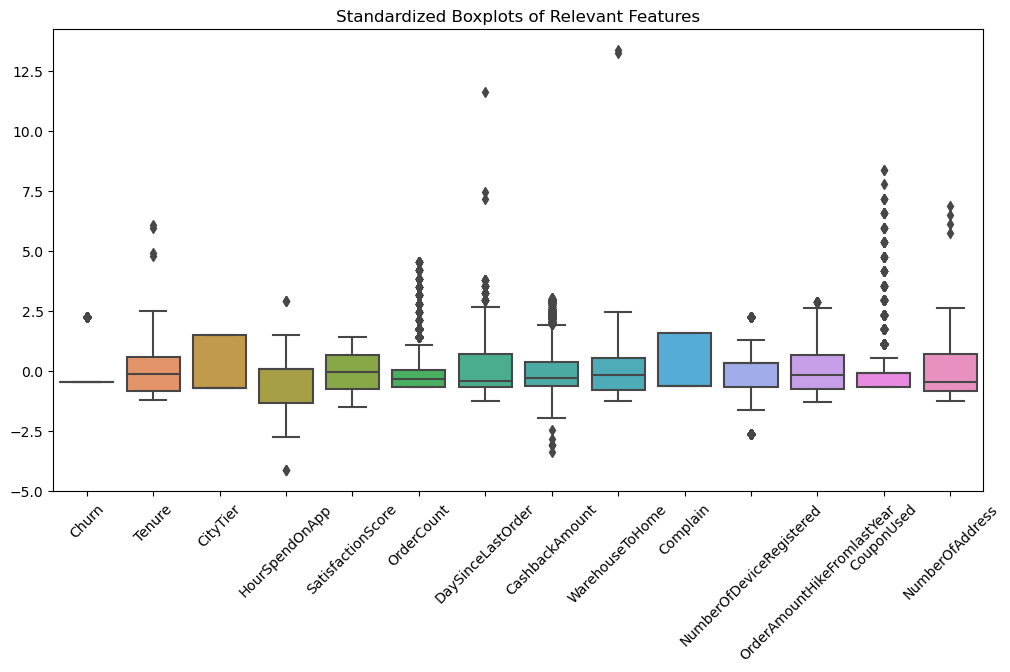

In [13]:
# 12. (b) Plot the boxplots for standardized features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_scaled)
plt.xticks(rotation=45)
plt.title("Standardized Boxplots of Relevant Features")
plt.show()

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

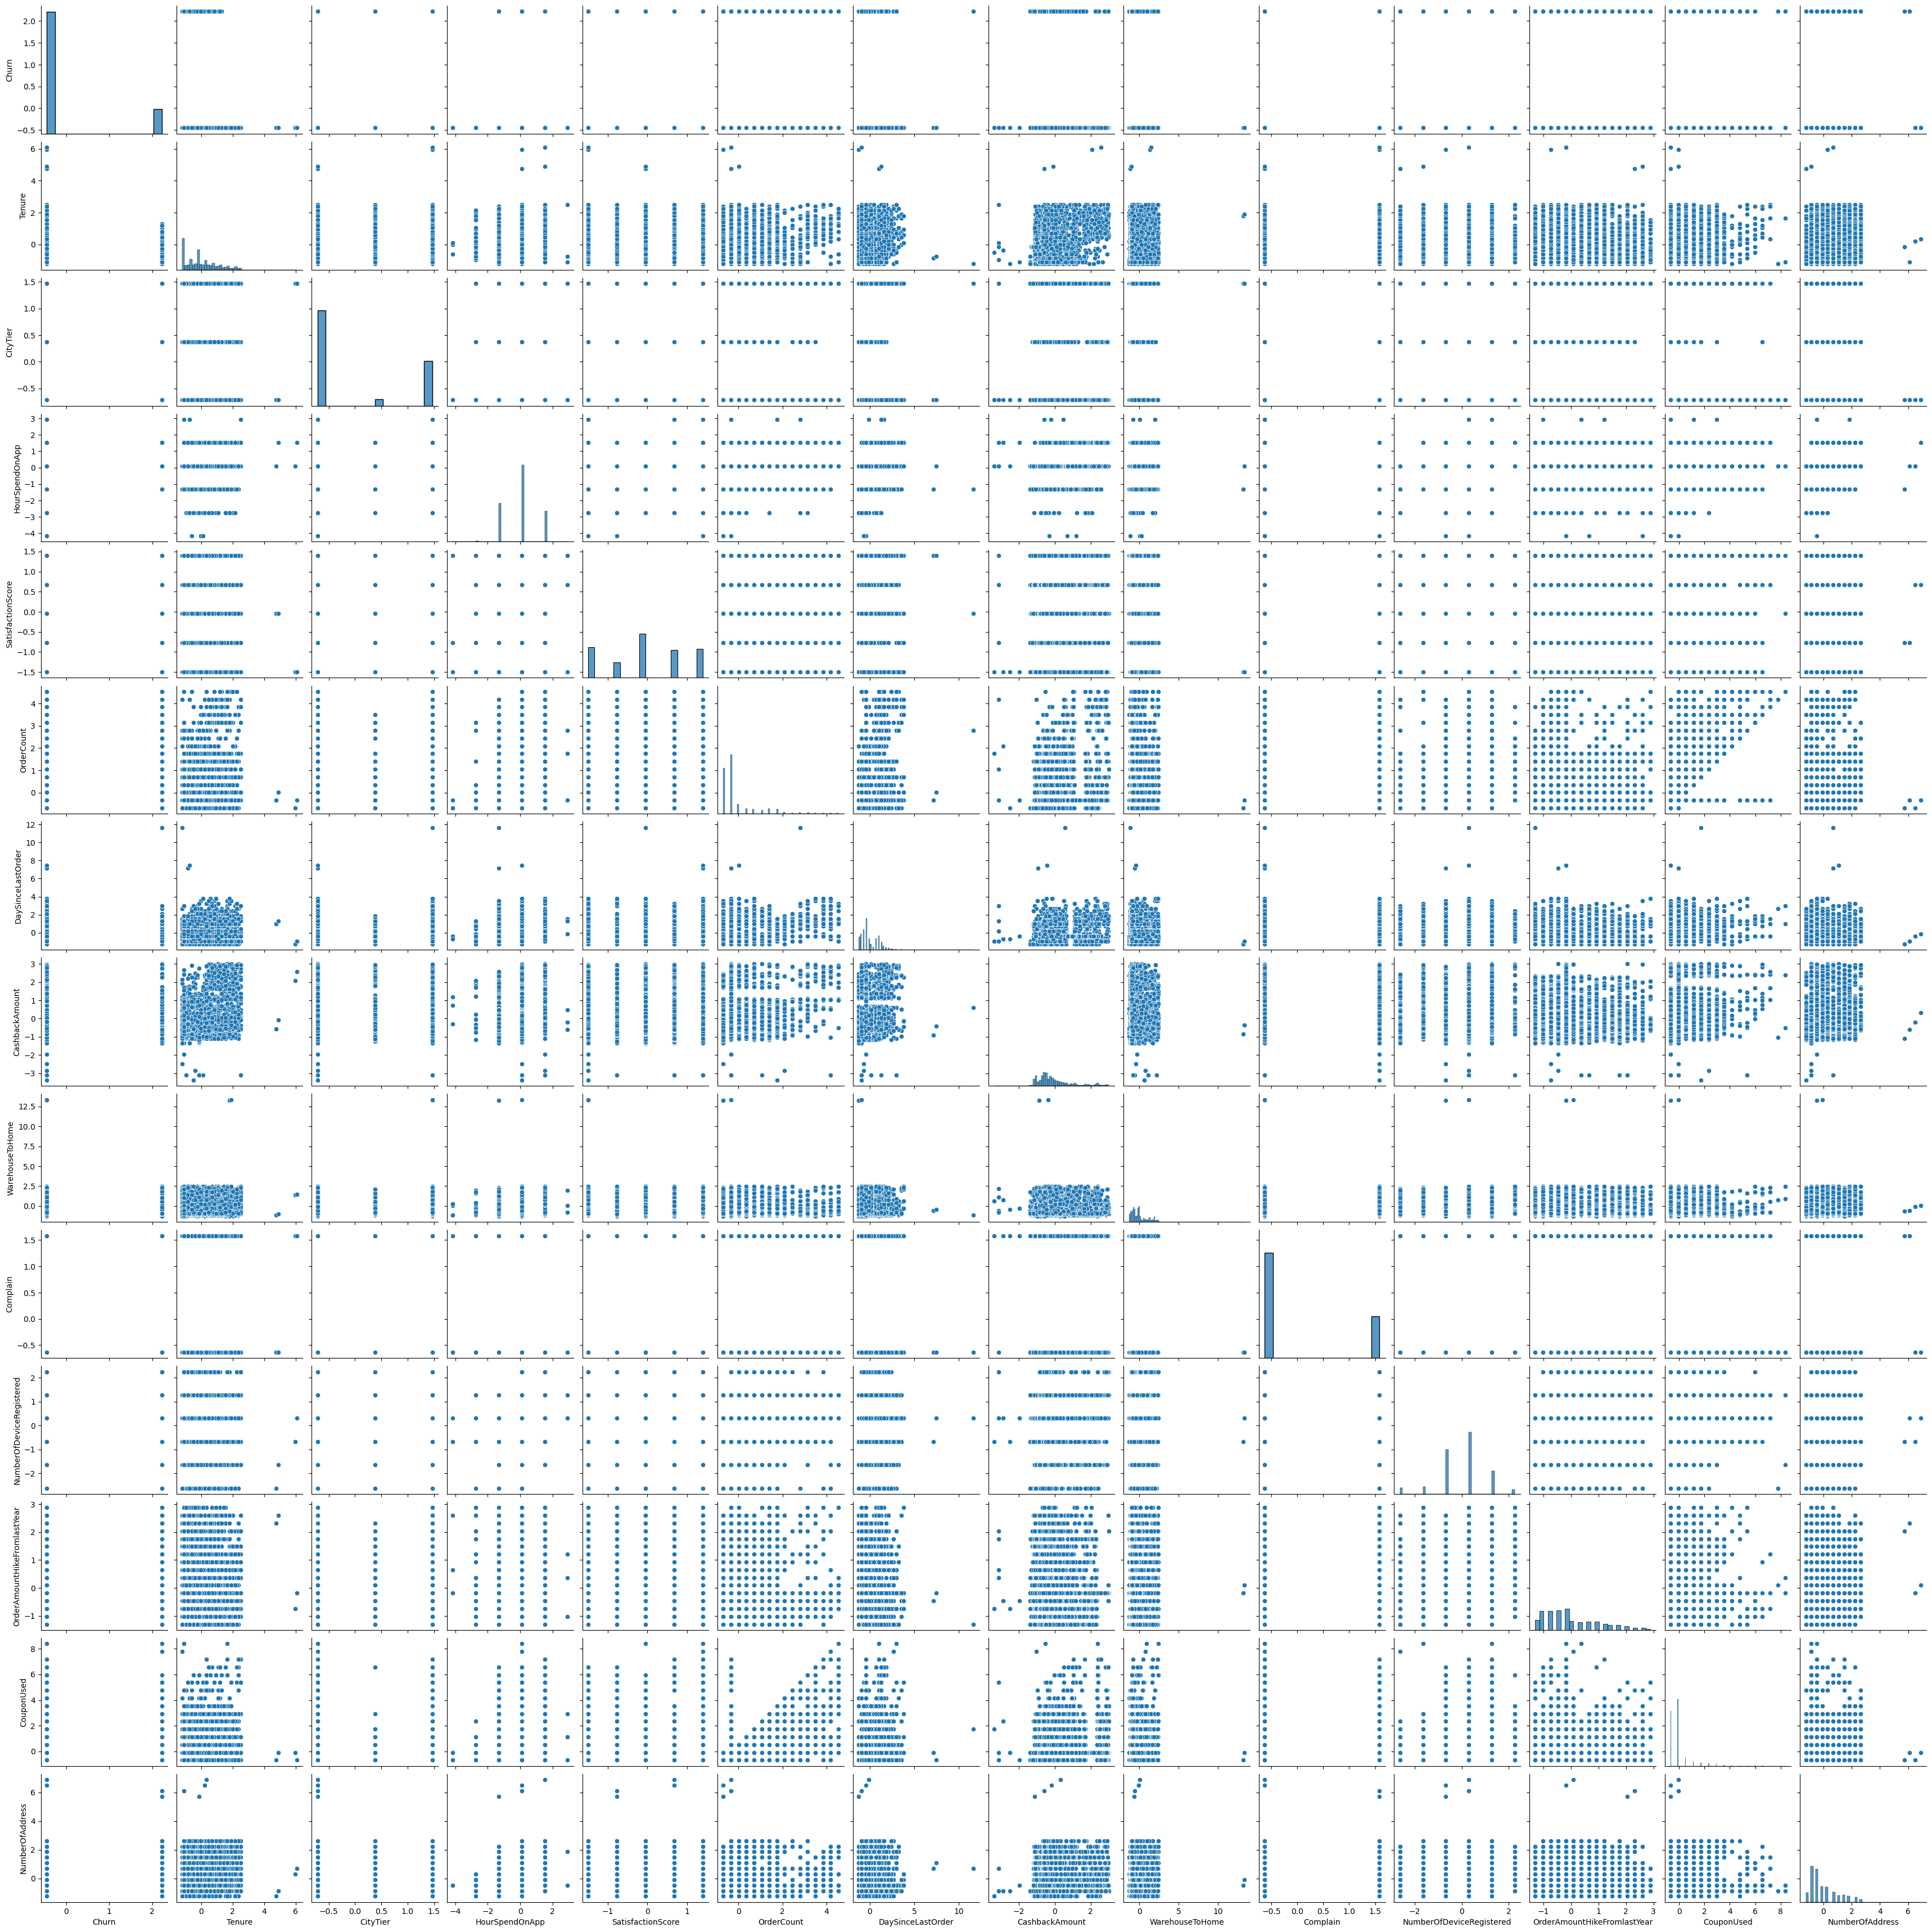

In [14]:
# 13. (c) Draw pairplots for the standardized features
sns.pairplot(df_scaled)
plt.show()

### Findings: Columns for Regression, Classification, and Clustering

**Regression:**
We can predict the following column values using regression:

| Column                      | Description                              |
|-----------------------------|------------------------------------------|
| WarehouseToHome             | Distance (e.g., kilometers/miles)        |
| HourSpendOnApp              | Time spent (e.g., hours)                 |
| OrderAmountHikeFromlastYear | Percentage increase (e.g., 15.5%)        |
| CashbackAmount              | Monetary value (e.g., $25.30)            |
| Tenure                      | Duration (e.g., 6.5 months)              |
| DaySinceLastOrder           | Continuous measure (e.g., 30.5 days)     |

**Classification:**
We can perform classification on the below columns:

| Column                     | Description                                       |
|----------------------------|---------------------------------------------------|
| Churn (target variable)    | Predict if a user churns or not                   |
| PreferredLoginDevice       | Preferred login device of customer                |
| PreferredPaymentMode       | Preferred payment method of customer              |
| PreferedOrderCat           | Preferred order category of customer in last month|
| MaritalStatus              | Marital status of customer                        |
| SatisfactionScore          | Satisfactory score of customer on service         |
| NumberOfDeviceRegistered   | Number of devices (e.g., 2 devices)               |
| NumberOfAddress            | Number of addresses (e.g., 3 addresses)           |
| CouponUsed                 | Number of coupons used (e.g., 5 coupons)          |
| OrderCount                 | Number of orders (e.g., 10 orders)                |
| Complain                   | 0 (No) / 1 (Yes)                                  |

**Clustering:**
Group using features: All continuous + encoded categorical/discrete columns

Group customers based on Tenure, CityTier, and CashbackAmount.

## Key Learnings and Difficulties

##### What Did We Learn from These Steps?

This assignment emphasized the importance of thorough data cleaning and understanding data distributions.
- Handling missing values required careful consideration of appropriate imputation methods.
- Visualizations revealed challenges in interpreting boxplots with limited data points.
- Difficulties included determining appropriate features for zero replacement and managing overlapping visualizations.
- The exercise highlighted that EDA is a repetitive process and showed how important it is to understand the subject area when cleaning and preparing data.


The columns showing the highest correlation with the target variable (Churn) are:
- Tenure
- OrderCount
- HourSpendOnApp

These columns can be used to build predictive models for customer churn. High correlation indicates that changes in these features are strongly associated with changes in the target variable. For instance, Tenure can help identify long-term customers who are less likely to churn, while Orderount and HourSpendOnApp can provide insights into customer engagement and purchasing behavior.


### End of Project_Part_2

### Begining of Project_Part_3

In [ ]:
#Calculate Pearson's correlation with 'Churn'
correlations = {}
for col in df.select_dtypes(include=['number']).columns:
    if col != "Churn":
        corr, _ = pearsonr(df[col], df["Churn"])
        correlations[col] = corr
        print(f"Pearson correlation between {col} and Churn: {corr:.3f}")

Pearson correlation between Tenure and Churn: -0.338
Pearson correlation between CityTier and Churn: 0.085
Pearson correlation between WarehouseToHome and Churn: 0.070
Pearson correlation between HourSpendOnApp and Churn: 0.019
Pearson correlation between NumberOfDeviceRegistered and Churn: 0.108
Pearson correlation between SatisfactionScore and Churn: 0.105
Pearson correlation between NumberOfAddress and Churn: 0.044
Pearson correlation between Complain and Churn: 0.250
Pearson correlation between OrderAmountHikeFromlastYear and Churn: -0.007
Pearson correlation between CouponUsed and Churn: -0.004
Pearson correlation between OrderCount and Churn: -0.024
Pearson correlation between DaySinceLastOrder and Churn: -0.156
Pearson correlation between CashbackAmount and Churn: -0.156


----- Univariate Random Forest Regression -----
Tenure: Test R² = 0.236, Pearson² = 0.114


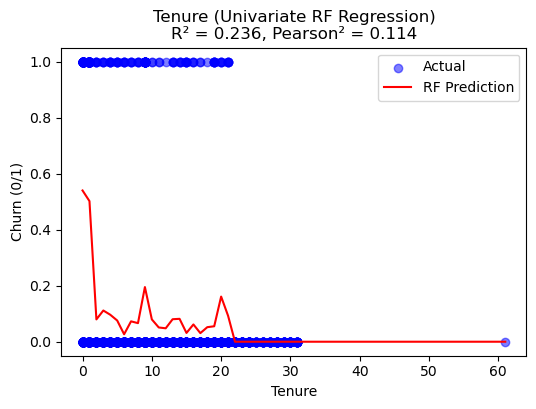

CityTier: Test R² = 0.001, Pearson² = 0.007


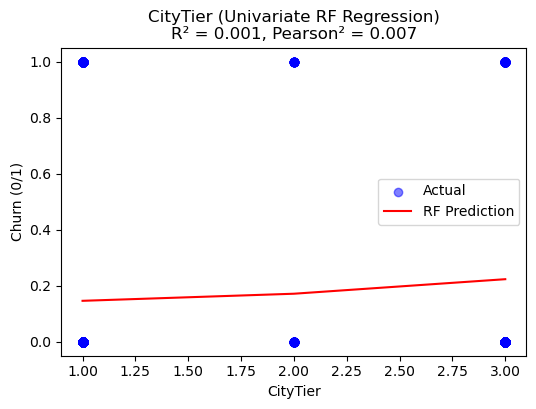

HourSpendOnApp: Test R² = 0.001, Pearson² = 0.000


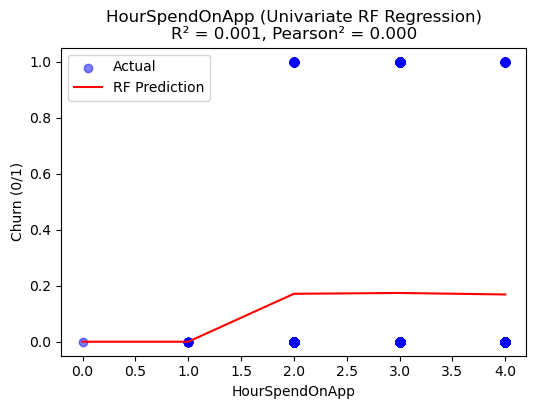

SatisfactionScore: Test R² = 0.015, Pearson² = 0.011


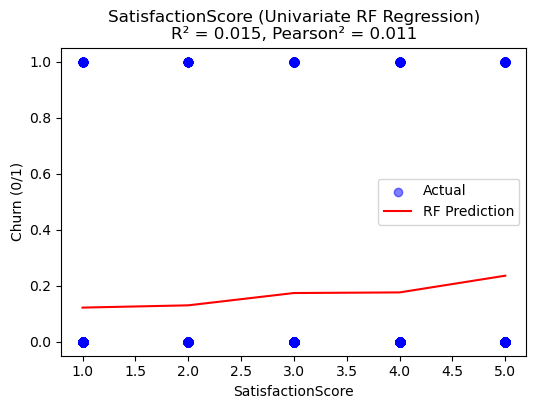

OrderCount: Test R² = -0.004, Pearson² = 0.001


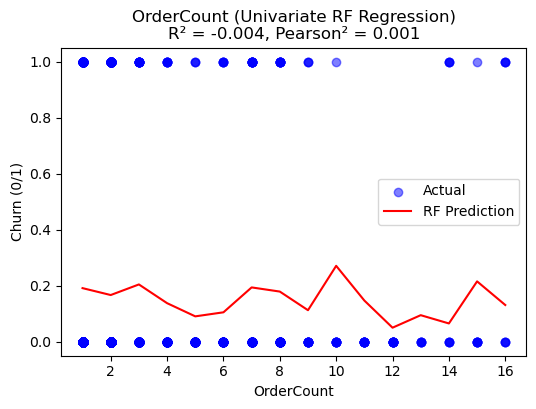

DaySinceLastOrder: Test R² = 0.025, Pearson² = 0.024


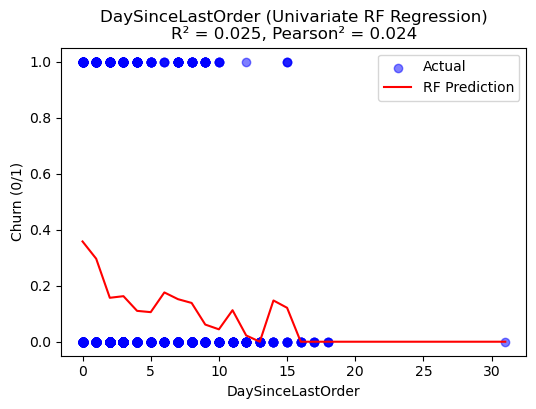

CashbackAmount: Test R² = 0.013, Pearson² = 0.024


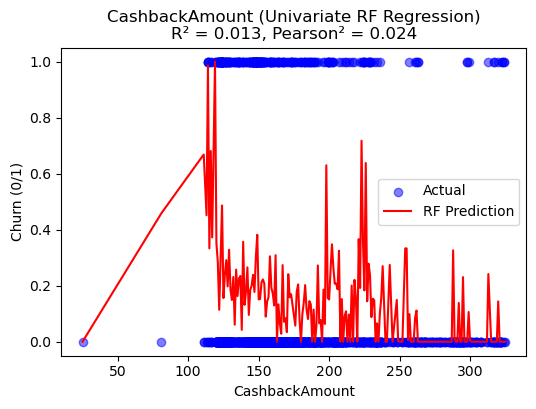

WarehouseToHome: Test R² = 0.006, Pearson² = 0.005


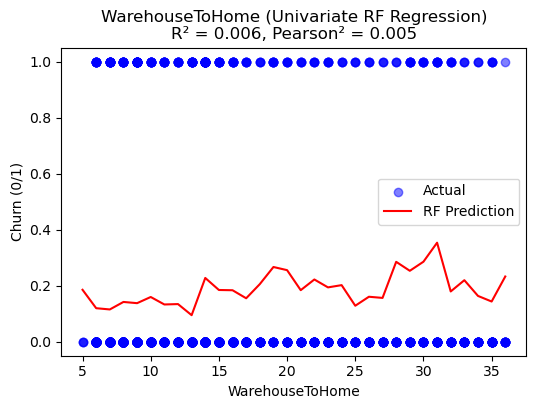

Complain: Test R² = 0.054, Pearson² = 0.063


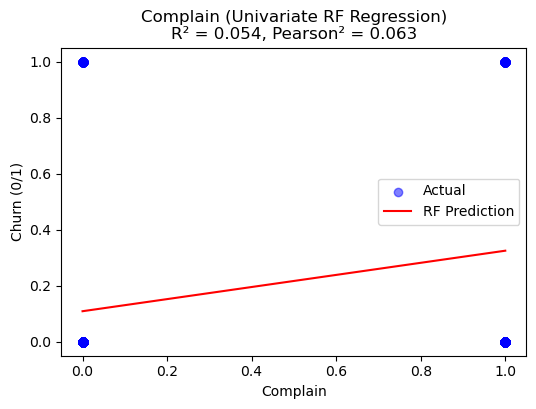

NumberOfDeviceRegistered: Test R² = 0.016, Pearson² = 0.012


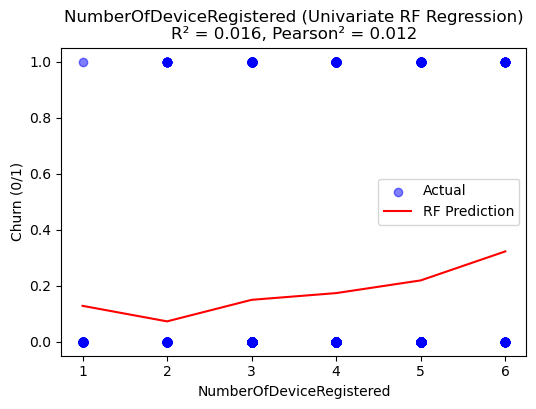

OrderAmountHikeFromlastYear: Test R² = 0.007, Pearson² = 0.000


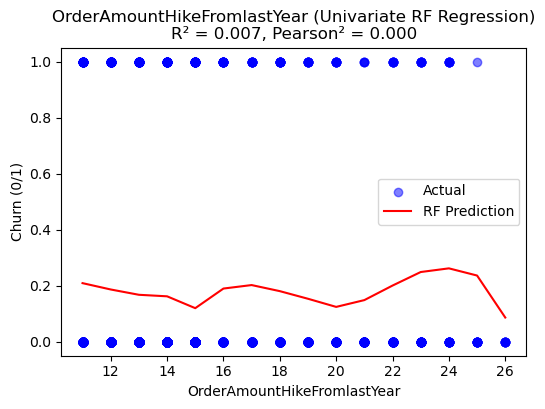

CouponUsed: Test R² = -0.004, Pearson² = 0.000


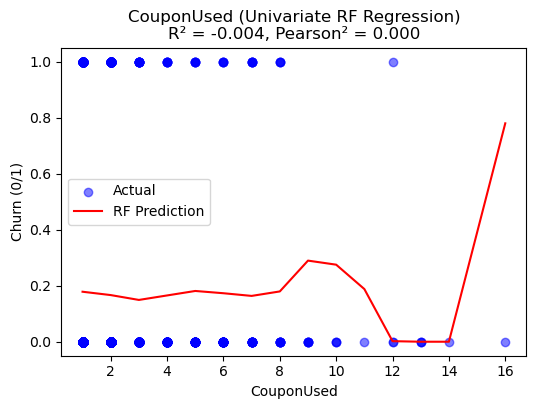

NumberOfAddress: Test R² = 0.013, Pearson² = 0.002


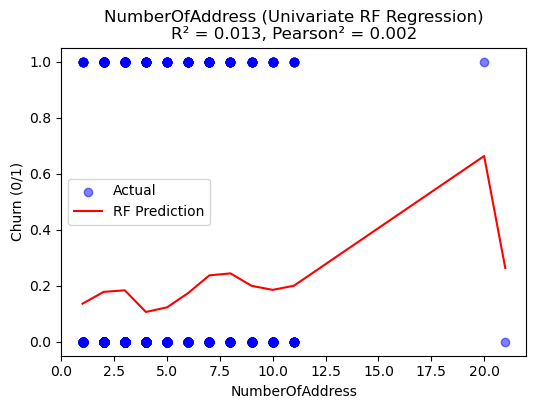

In [20]:
numeric_features = [col for col in df_filtered.select_dtypes(include=['number']).columns if col != "Churn"]

print("----- Univariate Random Forest Regression -----")
for col in numeric_features:
    X = df_filtered[[col]]
    y = df_filtered["Churn"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_reg.fit(X_train, y_train)

    y_pred = rf_reg.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    r, _ = pearsonr(df_filtered[col], df_filtered["Churn"])
    pearson_sq = r ** 2

    print(f"{col}: Test R² = {r2:.3f}, Pearson² = {pearson_sq:.3f}")

    plt.figure(figsize=(6,4))
    plt.scatter(X_test, y_test, color='blue', alpha=0.5, label="Actual")

    sorted_idx = np.argsort(X_test[col].values.flatten())
    plt.plot(X_test[col].values.flatten()[sorted_idx],
            y_pred[sorted_idx],
            color="red",
            label="RF Prediction")
    plt.xlabel(col)
    plt.ylabel("Churn (0/1)")
    plt.title(f"{col} (Univariate RF Regression)\nR² = {r2:.3f}, Pearson² = {pearson_sq:.3f}")
    plt.legend()
    plt.show()


Multivariate RF Regression: Test R² = 0.715


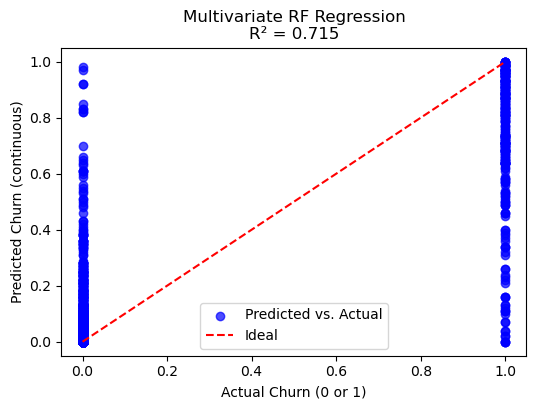

In [21]:
multivariate_predictors = [col for col in df_filtered.columns if col != "Churn"]

X_multi = df_filtered[multivariate_predictors]
y_multi = df_filtered["Churn"]

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_multi, y_multi, test_size=0.3, random_state=42)

rf_reg_multi = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg_multi.fit(X_train_m, y_train_m)

y_pred_m = rf_reg_multi.predict(X_test_m)
r2_multi = r2_score(y_test_m, y_pred_m)
print(f"\nMultivariate RF Regression: Test R² = {r2_multi:.3f}")

plt.figure(figsize=(6,4))
plt.scatter(y_test_m, y_pred_m, alpha=0.7, color='blue', label="Predicted vs. Actual")
plt.xlabel("Actual Churn (0 or 1)")
plt.ylabel("Predicted Churn (continuous)")
plt.title(f"Multivariate RF Regression\nR² = {r2_multi:.3f}")

plt.plot([0,1], [0,1], color='red', linestyle='--', label="Ideal")
plt.legend()
plt.show()

In [22]:
X_clf = df_filtered[multivariate_predictors]
y_clf = df_filtered["Churn"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clf, y_clf, test_size=0.3, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_c, y_train_c)

y_pred_c = rf_clf.predict(X_test_c)
y_pred_prob_c = rf_clf.predict_proba(X_test_c)[:, 1]

accuracy = accuracy_score(y_test_c, y_pred_c)
roc_auc = roc_auc_score(y_test_c, y_pred_prob_c)
print(f"Multivariate RF Classification -- Accuracy: {accuracy:.3f}, ROC AUC: {roc_auc:.3f}")

Multivariate RF Classification -- Accuracy: 0.960, ROC AUC: 0.971


### Key Learnings from Prpject Part 2


#### In Project Part 3, we focused on understanding the correlation between features and the target variable, Churn. We learned that features like Tenure, OrderCount, and HourSpendOnApp have significant correlations with Churn, which can be leveraged to build predictive models.
#### We also plotted scatterplots for each column to predict churn and found that multiple feature' values help in predicting churn effectively. This multivariate approach provided a more accurate prediction model compared to univariate models. The RandomForestClassifier and RandomForestRegressor were instrumental in achieving high accuracy and R² scores.

### End of Project_Part_3